# 6hr Moon observation analysis

In [10]:
import ugradio
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.table as Table
from datetime import datetime
from datetime import timedelta
import time
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy

%matplotlib inline
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 17})

## Loading in the data

Data was collected on Sunday, March 20, 2022 beginning at 1:19:03 am and ending on 07:18:39 am (PST).

In [2]:
volts, times = np.load('Data/6hr_moon_data.npy')
volts.shape

(21577,)

### Getting the times of observation in PST and JD:

In [3]:
beginning_time = min(times)
ending_time = max(times)

beginning_local_time = ugradio.timing.local_time(beginning_time)
ending_local_time = ugradio.timing.local_time(ending_time)

beginning_jd = ugradio.timing.julian_date(beginning_time)
ending_jd = ugradio.timing.julian_date(ending_time)


print('Beginning time in local time (PST):', beginning_local_time, '\nEnding time in local time (PST):', ending_local_time)

print('\nBeginning JD:', beginning_jd, '\nEnding JD:', ending_jd)

# beginning_local_time[11:19]

Beginning time in local time (PST): Sun Mar 20 01:19:03 2022 
Ending time in local time (PST): Sun Mar 20 07:18:39 2022

Beginning JD: 2459658.846565039 
Ending JD: 2459659.096287269


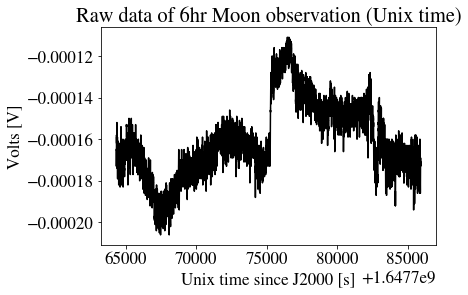

In [4]:
plt.figure()
plt.title('Raw data of 6hr Moon observation (Unix time)')
plt.plot(times, volts, 'k')
plt.xlabel('Unix time since J2000 [s]')
plt.ylabel('Volts [V]')
plt.show()

In [5]:
v_inter = np.median(np.diff(times))

freqs = np.fft.fftfreq(len(times), v_inter)

power = np.abs(np.fft.fft(volts))**2

<IPython.core.display.Javascript object>


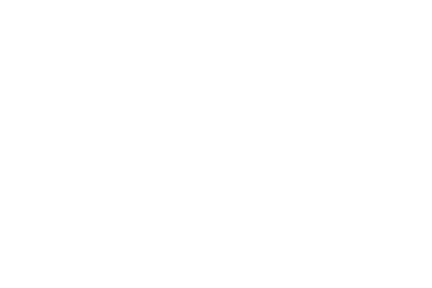

<IPython.core.display.Javascript object>


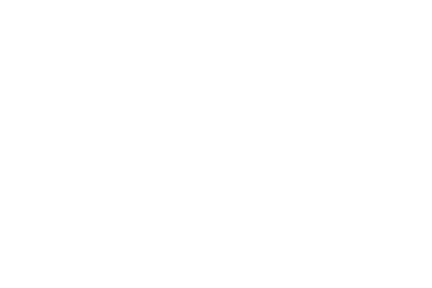

In [6]:
%matplotlib notebook

plt.figure()
plt.plot(freqs, power, 'k')
# plt.xlim(0,0.05)
# plt.ylim(0,0.01)
plt.show()

In [7]:
def pow_fft(arr):
    return np.fft.fftshift(np.abs(np.fft.fft(arr))**2)

def freq(arr, dt):
    return np.fft.fftshift(np.fft.fftfreq(len(arr), dt))


def split_data(data, time, num_splits):
    n = len(data)
    split_size = n // num_splits
    data_splits = []
    freq_splits = []
    for i in range(num_splits):
        data_frac = data[i*split_size:(i+1)*split_size]
        time_frac = time[i*split_size:(i+1)*split_size]
        dt = np.mean(np.diff(time_frac))
        frequency = freq(time_frac, dt)
        pow_frac = pow_fft(data_frac)
        
        data_splits.append(pow_frac)
        freq_splits.append(frequency)
        
    return data_splits, freq_splits

In [45]:
split_power, split_freqs = split_data(volts, times, 12)

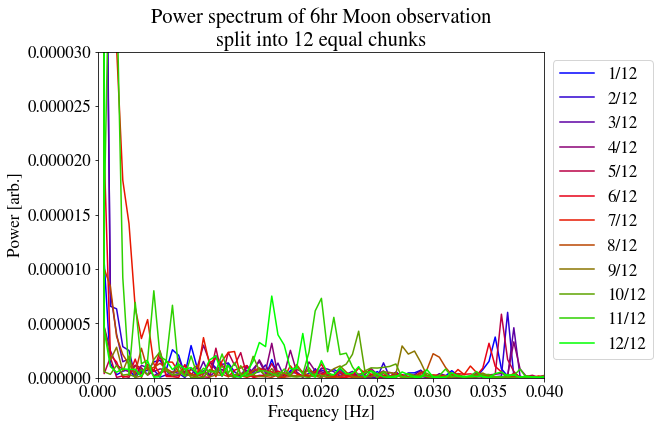

In [48]:
# %matplotlib inline
cmap = plt.cm.brg
n = len(split_power)
colors = cmap(np.linspace(0,1,n))


plt.figure(figsize=(8,6))
plt.title('Power spectrum of 6hr Moon observation\nsplit into {0:.0f} equal chunks'.format(len(split_power)))

labels = []
for i in range(len(split_power)):
    label = '{0:.0f}/{1:.0f}'.format(i+1, len(split_power))
    labels.append(label)

for i in range(len(split_power)):
    plt.plot(split_freqs[i], split_power[i], label=labels[i], color=colors[i])
    
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
# plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [arb.]')
plt.xlim(0,0.04)
plt.ylim(0,.00003)
plt.show()